# Import data and dependencies

In [ ]:
!pip install underthesea matplotlib==3.7.3 seaborn wordcloud jupyternotify

In [ ]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from underthesea import text_normalize, word_tokenize
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('crawled.csv')
df.head()

,title,link,category
0,Việt Nam sẵn sàng cùng IMF triển khai các biện...,https://vietnamnet.vn/khong-chinh-tri-hoa-cac-...,Politics
1,Thủ tướng: Trung Quốc và ASEAN cần mở cửa thị ...,https://vietnamnet.vn/thu-tuong-trung-quoc-va-...,Politics
2,Thủ tướng khai trương khu gian hàng Việt Nam t...,https://vietnamnet.vn/thu-tuong-khai-truong-kh...,Politics
3,Thủ tướng đề nghị Indonesia công nhận nỗ lực c...,https://vietnamnet.vn/thu-tuong-de-nghi-indone...,Politics
4,"Thủ tướng mong doanh nghiệp ASEAN đoàn kết, 't...",https://vietnamnet.vn/thu-tuong-mong-doanh-ngh...,Politics


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59958 entries, 0 to 59957
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     59958 non-null  object
 1   link      59958 non-null  object
 2   category  59958 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


# Pre-processing

## Drop 'link' column and encode the label

In [4]:
category_mapping = {
    'Politics': 0,
    'Business': 1,
    'Sports': 2,
    'Education': 3,
    'Wellness': 4,
    'Entertainment': 5
}

df.drop(columns=['link'], inplace=True)

df['category'] = df['category'].map(category_mapping)

df.head()

,title,category
0,Việt Nam sẵn sàng cùng IMF triển khai các biện...,0
1,Thủ tướng: Trung Quốc và ASEAN cần mở cửa thị ...,0
2,Thủ tướng khai trương khu gian hàng Việt Nam t...,0
3,Thủ tướng đề nghị Indonesia công nhận nỗ lực c...,0
4,"Thủ tướng mong doanh nghiệp ASEAN đoàn kết, 't...",0


## Unicode normalization

In [5]:
import unicodedata


def unicode_normalize(text):
    return unicodedata.normalize('NFC', text)

df['title'] = df['title'].apply(unicode_normalize)

df.head()

,title,category
0,Việt Nam sẵn sàng cùng IMF triển khai các biện...,0
1,Thủ tướng: Trung Quốc và ASEAN cần mở cửa thị ...,0
2,Thủ tướng khai trương khu gian hàng Việt Nam t...,0
3,Thủ tướng đề nghị Indonesia công nhận nỗ lực c...,0
4,"Thủ tướng mong doanh nghiệp ASEAN đoàn kết, 't...",0


## Remove special characters and numbers

In [6]:
def clean_text(text):
    pattern = r'[^a-zA-Z\sÀ-ỹ]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

df['title'] = df['title'].apply(clean_text)

df.head()

,title,category
0,Việt Nam sẵn sàng cùng IMF triển khai các biện...,0
1,Thủ tướng Trung Quốc và ASEAN cần mở cửa thị t...,0
2,Thủ tướng khai trương khu gian hàng Việt Nam t...,0
3,Thủ tướng đề nghị Indonesia công nhận nỗ lực c...,0
4,Thủ tướng mong doanh nghiệp ASEAN đoàn kết tro...,0


## Spelling normalization

In [7]:
def spelling_normalize(text):
    text = text.replace('kĩ','kỹ').replace('mỳ', 'mì').replace('sỹ', 'sĩ').replace('lí ',' lý ')

    return text

df['title'] = df['title'].apply(spelling_normalize).apply(text_normalize)

df.head()

,title,category
0,Việt Nam sẵn sàng cùng IMF triển khai các biện...,0
1,Thủ tướng Trung Quốc và ASEAN cần mở cửa thị t...,0
2,Thủ tướng khai trương khu gian hàng Việt Nam t...,0
3,Thủ tướng đề nghị Indonesia công nhận nỗ lực c...,0
4,Thủ tướng mong doanh nghiệp ASEAN đoàn kết tro...,0


## Tokenization

In [8]:
%%notify
tkn_df = df.copy()

tkn_df['title'] = tkn_df['title'].apply(lambda sentence: word_tokenize(sentence, format='text'))

tkn_df.head()

,title,category
0,Việt_Nam sẵn_sàng cùng IMF triển_khai các biện...,0
1,Thủ_tướng Trung_Quốc và ASEAN cần mở_cửa thị_t...,0
2,Thủ_tướng khai_trương khu gian_hàng Việt_Nam t...,0
3,Thủ_tướng đề_nghị Indonesia công_nhận nỗ_lực c...,0
4,Thủ_tướng mong doanh_nghiệp ASEAN đoàn_kết tro...,0


## Capitalization (lower case)

In [9]:
tkn_df['title'] = tkn_df['title'].str.lower()

tkn_df.head()

,title,category
0,việt_nam sẵn_sàng cùng imf triển_khai các biện...,0
1,thủ_tướng trung_quốc và asean cần mở_cửa thị_t...,0
2,thủ_tướng khai_trương khu gian_hàng việt_nam t...,0
3,thủ_tướng đề_nghị indonesia công_nhận nỗ_lực c...,0
4,thủ_tướng mong doanh_nghiệp asean đoàn_kết tro...,0


## Stopwords

In [10]:
with open('stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = file.readlines()
stopwords = [word.replace('\n', '') for word in stopwords]
print(stopwords)

['bị', 'bởi', 'cả', 'các', 'cái', 'cần', 'càng', 'chỉ', 'chiếc', 'cho', 'chứ', 'chưa', 'chuyện', 'có', 'có_thể', 'cứ', 'của', 'cùng', 'cũng', 'đã', 'đang', 'đây', 'để', 'đến_nỗi', 'đều', 'điều', 'do', 'đó', 'được', 'dưới', 'gì', 'hơn', 'ít', 'khi', 'không', 'là', 'lại', 'lên', 'lúc', 'mà', 'mỗi', 'một', 'một_cách', 'này', 'nên', 'nếu', 'ngay', 'nhất', 'nhiều', 'như', 'nhưng', 'những', 'nơi', 'nữa', 'ở', 'phải', 'qua', 'ra', 'rằng', 'rằng', 'rất', 'rất', 'rồi', 'sau', 'sẽ', 'so', 'sự', 'tại', 'theo', 'thì', 'trên', 'trong', 'trước', 'từ', 'từng', 'và', 'vẫn', 'vào', 'vậy', 'về', 'vì', 'việc', 'với', 'vừa']


## Remove stopwords

In [11]:
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stopwords]

    return ' '.join(words)

tkn_df['title'] = tkn_df['title'].apply(remove_stopwords)
tkn_df.head()

,title,category
0,việt_nam sẵn_sàng imf triển_khai biện_pháp thú...,0
1,thủ_tướng trung_quốc asean mở_cửa thị_trường c...,0
2,thủ_tướng khai_trương khu gian_hàng việt_nam h...,0
3,thủ_tướng đề_nghị indonesia công_nhận nỗ_lực v...,0
4,thủ_tướng mong doanh_nghiệp asean đoàn_kết tôi...,0


# Exploratory Data Analysis

## Numbers of articles by category

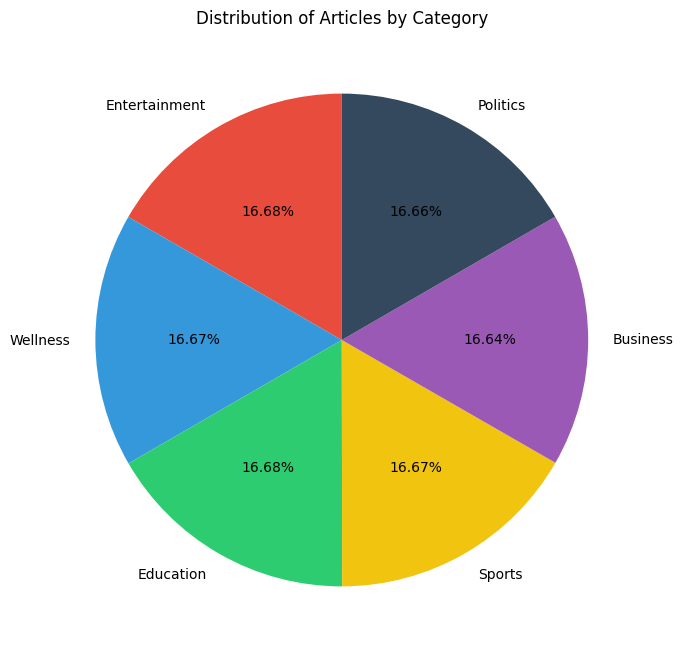

In [ ]:
temp = pd.read_csv('crawled.csv')

category_order = ['Politics', 'Business', 'Sports', 'Education', 'Wellness', 'Entertainment']
custom_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F1C40F', '#9B59B6', '#34495E']

category_counts = temp['category'].value_counts().loc[category_order[::-1]]

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.2f%%', startangle=90, colors=custom_colors)
plt.title('Distribution of Articles by Category')

plt.show()

## Average sentence length

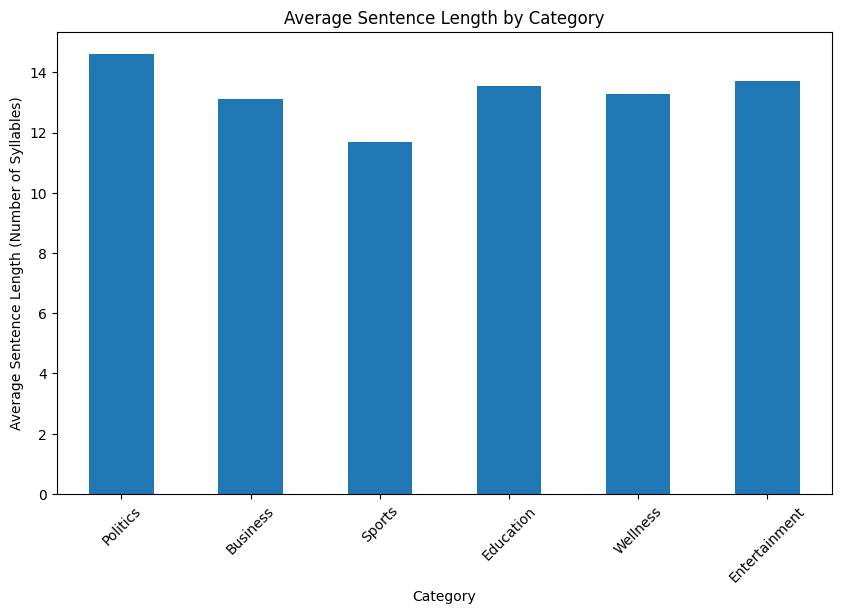

In [ ]:
temp = pd.read_csv('crawled.csv')

category_order = ['Politics', 'Business', 'Sports', 'Education', 'Wellness', 'Entertainment']

temp['sentence_length'] = temp['title'].apply(lambda x: len(x.split()))
average_sentence_length = temp.groupby('category')['sentence_length'].mean().reindex(category_order)

plt.figure(figsize=(10, 6))
average_sentence_length.plot(kind='bar')
plt.title('Average Sentence Length by Category')
plt.xlabel('Category')
plt.ylabel('Average Sentence Length (Number of Syllables)')
plt.xticks(rotation=45)
plt.show()

## Word clouds (Most popular words by category)

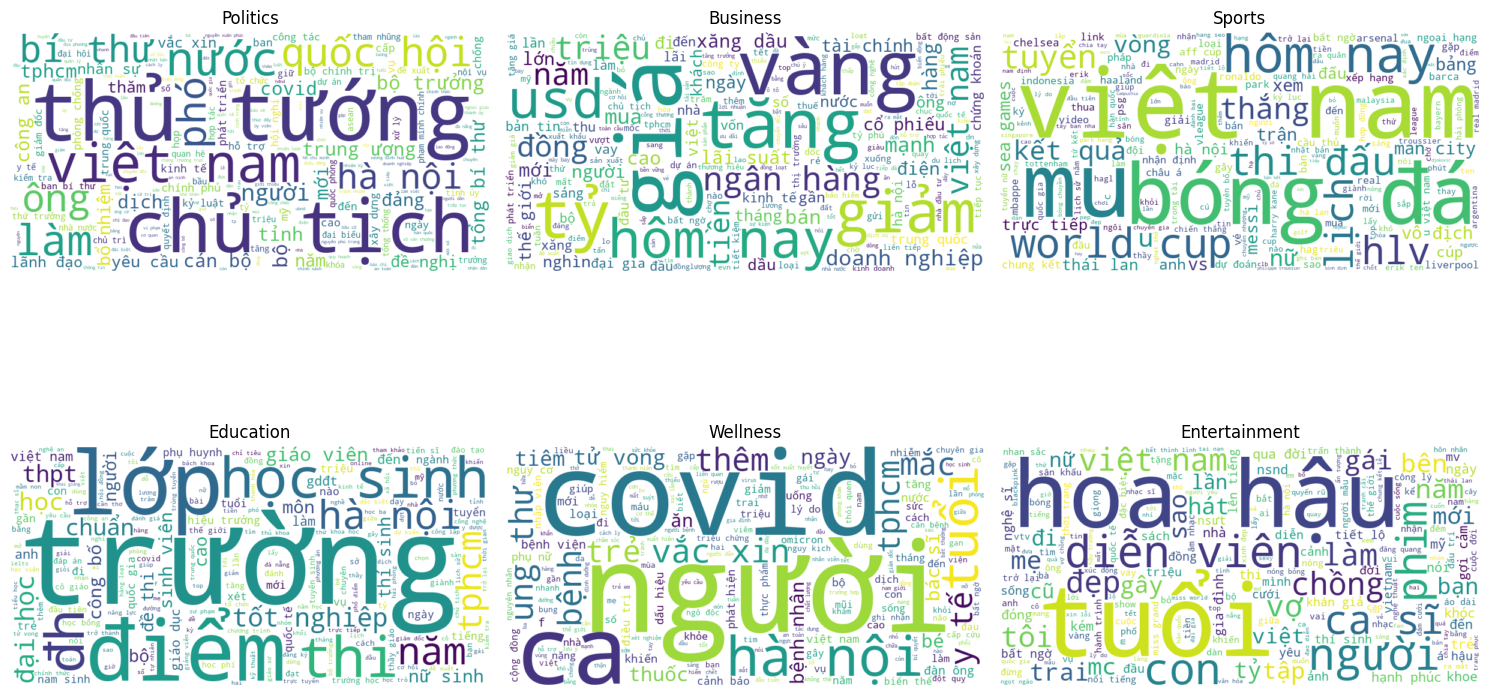

In [53]:
from collections import Counter

temp_tkn_df = tkn_df.copy()
temp_tkn_df['title'] = temp_tkn_df['title'].apply(lambda x: [word.replace('_', ' ') for word in x.split()])

category_names = ['Politics', 'Business', 'Sports', 'Education', 'Wellness', 'Entertainment']
wordclouds = []

for category in range(6):
    category_data = temp_tkn_df[temp_tkn_df['category'] == category]

    all_titles = [item for sublist in category_data['title'] for item in sublist]

    word_counts = Counter(all_titles)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

    wordclouds.append(wordcloud)

plt.figure(figsize=(15, 10))

for i, wordcloud in enumerate(wordclouds):
    plt.subplot(2, 3, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(category_names[i])

plt.tight_layout()
plt.show()

## Words with highest and lowest frequency in the data set

In [13]:
temp_tkn_df = tkn_df.copy()
temp_tkn_df['title'] = temp_tkn_df['title'].apply(lambda x: [word.replace('_', ' ') for word in x.split()])

all_words = [word for title in temp_tkn_df['title'] for word in title]
word_frequency = {}
total_titles = len(temp_tkn_df)

for word in all_words:
    if word in word_frequency:
        word_frequency[word] += 1
    else:
        word_frequency[word] = 1

word_frequencies = {word: freq / total_titles for word, freq in word_frequency.items()}

word_frequency_df = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Frequency'])
word_frequency_df = word_frequency_df.sort_values(by='Frequency', ascending=False)

word_frequency_df = word_frequency_df.reset_index(drop=True)
word_frequency_df.head(10)

,Word,Frequency
0,việt nam,0.078655
1,người,0.062544
2,hà nội,0.048567
3,năm,0.044865
4,giá,0.040262
5,covid,0.039094
6,thủ tướng,0.036042
7,hôm nay,0.035925
8,tphcm,0.033707
9,làm,0.033657


As we can see, there is no word whose frequency greater than 10%. Thus, we don't have any 'corpus-specific' stopwords in the dataset.

In [54]:
word_frequency_df.tail(10)

,Word,Frequency
32429,việt nam luyện,0.000017
32430,cực đỉnh,0.000017
32431,cầu môn,0.000017
32432,mỹ đình cỏ,0.000017
32433,ngoai,0.000017
32434,psg fan,0.000017
32435,pga tour,0.000017
32436,sergio aguero,0.000017
32437,tottenham thoát,0.000017
32438,trịnh tự,0.000017


There's a lot of rare and weird words showing here.

## Zipf's Law distribution

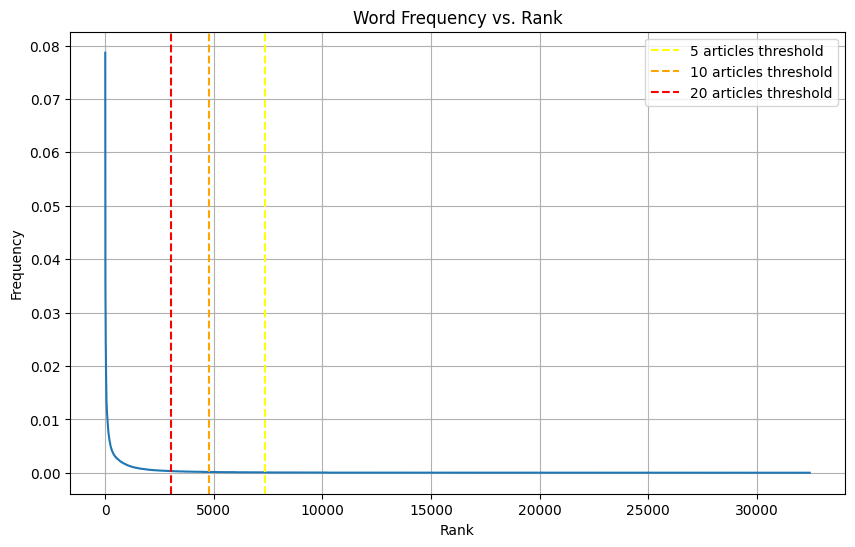

In [22]:
threshold_indices = [word_frequency_df[word_frequency_df['Frequency'] < (x/59958)].index[0] for x in [5, 10, 20]]
threshold_colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 6))
plt.plot(word_frequency_df.index, word_frequency_df['Frequency'], linestyle='-')

for threshold_index, threshold_color, threshold_value in zip(threshold_indices, threshold_colors, [5, 10, 20]):
    plt.axvline(x=threshold_index, color=threshold_color, linestyle='--', label=f'{threshold_value} articles threshold')

plt.title('Word Frequency vs. Rank')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Feature extraction (TF-IDF)

In [55]:
corpus = tkn_df.copy()
corpus['title'] = corpus['title'].astype(str)

We removed rare words (and weird words caused by tokenizer) which are shown in less than 10 articles by setting the parameter min_df=10 to limit the vocabulary size. This will avoid overfitting and tremendously reduce computational cost later on.

In [ ]:
vectorizer = TfidfVectorizer(min_df=10)
features = vectorizer.fit_transform(corpus['title'])

joblib.dump(vectorizer, 'models/tfidf.joblib')
tfidf_df = pd.DataFrame(data=features.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df['category'] = corpus['category']
tfidf_df.head()

,a_bank,a_vòng,ac,adeno,afc,aff,aff_cup,agribank,ai,ai_cập,...,ủy,ủy_ban,ủy_viên,ức_chế,ứng_cử,ứng_dụng,ứng_phó,ứng_viên,ứng_xử,category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Number of features reduces to 4759 from 32437

# Data splitting

In [ ]:
# train_df, temp_df = train_test_split(tfidf_df, test_size=0.2, stratify=tfidf_df['category'], random_state=42)
# val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['category'], random_state=42)

# train_df.to_csv('df/train_df.csv', index=False)
# val_df.to_csv('df/val_df.csv', index=False)
# test_df.to_csv('df/test_df.csv', index=False)

# Hyperparameter tuning

In [ ]:
%%notify
train_df = pd.read_csv('df/train_df.csv')
val_df = pd.read_csv('df/val_df.csv')
test_df = pd.read_csv('df/test_df.csv')

X_train = train_df.drop(columns=['category'])
y_train = train_df['category']

X_val = val_df.drop(columns=['category'])
y_val = val_df['category']

X_test = test_df.drop(columns=['category'])
y_test = test_df['category']

<IPython.core.display.Javascript object>

## Naive Bayes

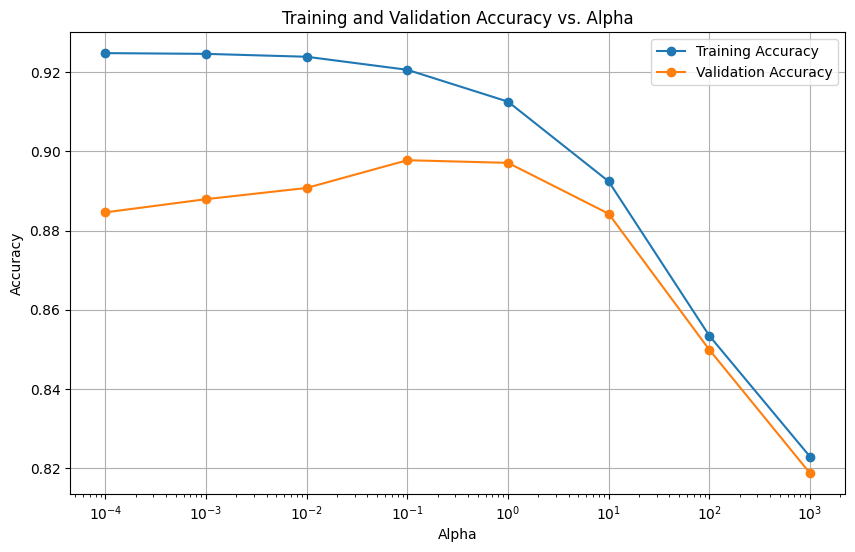

In [ ]:
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for alpha in alpha_values:
    clf = MultinomialNB(alpha=alpha, fit_prior=True)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(alpha_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Alpha')
plt.grid(True)
plt.legend()
plt.show()

## k-Nearest Neighbors

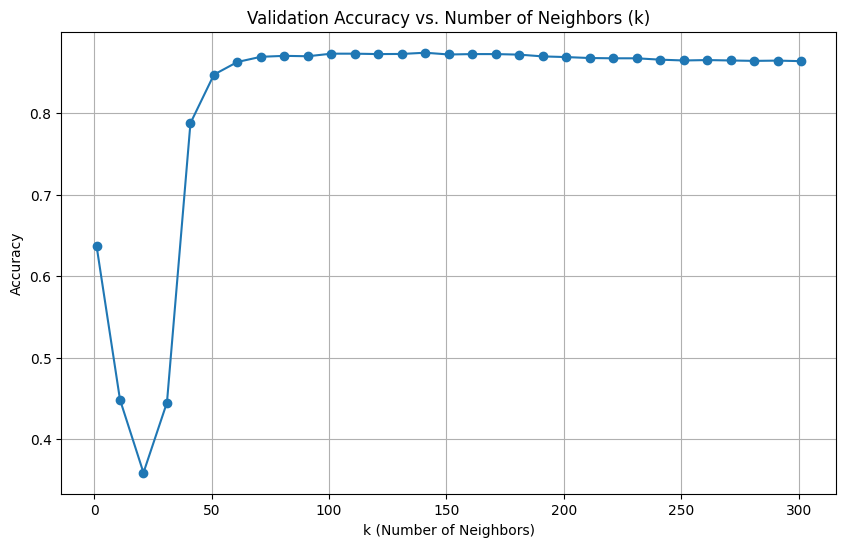

<IPython.core.display.Javascript object>

In [ ]:
%%notify
k_values = range(1, 302, 10)
validation_accuracies = []

with joblib.parallel_backend('loky'):
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(k_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Number of Neighbors (k)')
plt.grid(True)
plt.show()

In [ ]:
%%notify
param_grid = {
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

results = []

for weight in param_grid['weights']:
    for metric in param_grid['metric']:
        with joblib.parallel_backend('loky'):
            clf = KNeighborsClassifier(n_neighbors=101, weights=weight, metric=metric, n_jobs=-1)

            clf.fit(X_train, y_train)

            y_val_pred = clf.predict(X_val)
            accuracy = accuracy_score(y_val, y_val_pred)

            results.append({
                'weights': weight,
                'distance_metric': metric,
                'accuracy': accuracy
            })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='accuracy', ascending=False)
results_df.reset_index(drop=True, inplace=True)

display(results_df)

,weights,distance_metric,accuracy
0,distance,cosine,0.880754
1,uniform,cosine,0.876084
2,uniform,euclidean,0.872748
3,distance,euclidean,0.870247
4,uniform,manhattan,0.576718
5,distance,manhattan,0.567045


<IPython.core.display.Javascript object>

## Logistic Regression

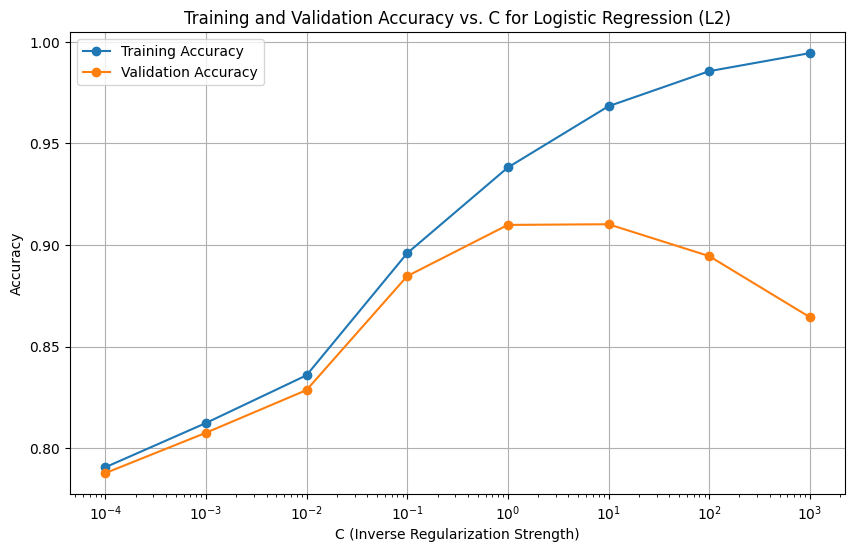

In [ ]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for C in C_values:
    with joblib.parallel_backend('loky'):
        clf = LogisticRegression(C=C, max_iter=10000, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(C_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. C for Logistic Regression (L2)')
plt.grid(True)
plt.legend()
plt.show()

## Support Vector Machine

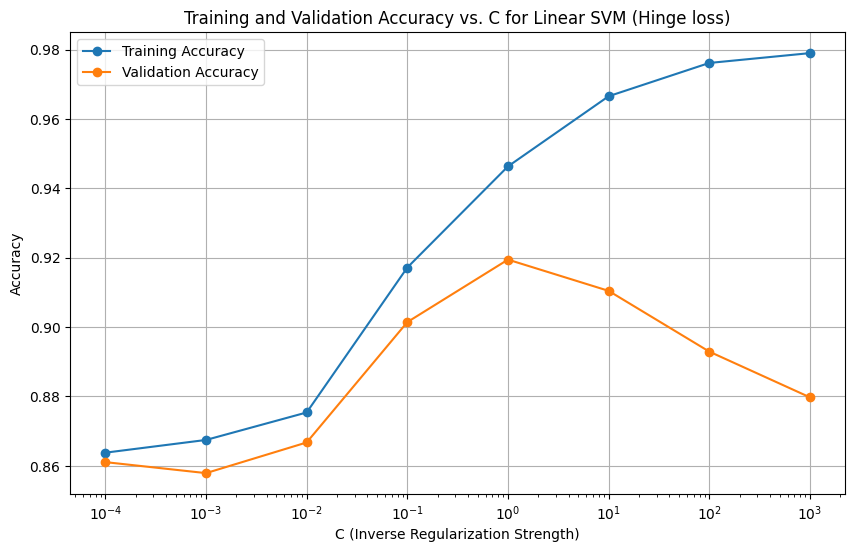

<IPython.core.display.Javascript object>

In [ ]:
%%notify
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for C in C_values:
    clf = LinearSVC(C=C, loss='hinge', max_iter=10000)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(C_values, validation_accuracies, marker='o', label='Validation Accuracy')

plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. C for Linear SVM (Hinge loss)')
plt.grid(True)
plt.legend()
plt.show()

## Random Forest

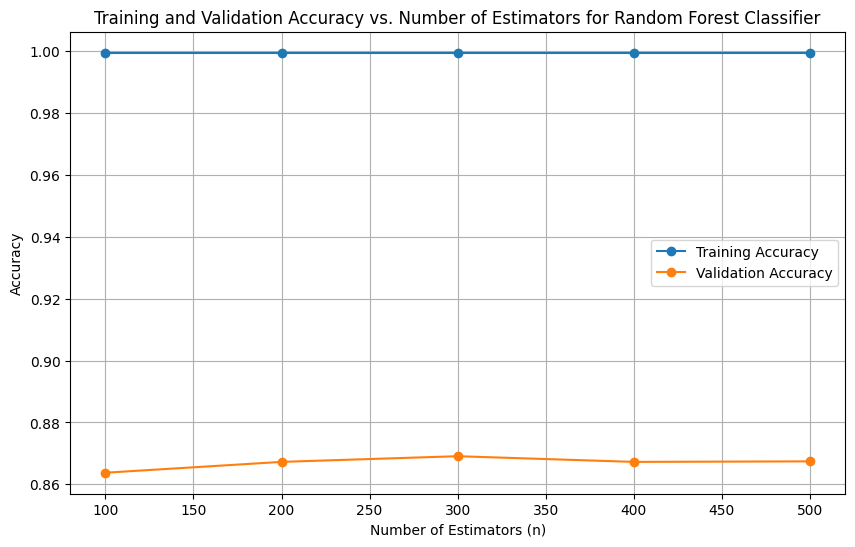

<IPython.core.display.Javascript object>

In [ ]:
%%notify
n_values = range(100, 501, 100)
train_accuracies = []
validation_accuracies = []

for n in n_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(n_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(n_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Number of Estimators (n)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Estimators for Random Forest Classifier')
plt.grid(True)
plt.legend()
plt.show()

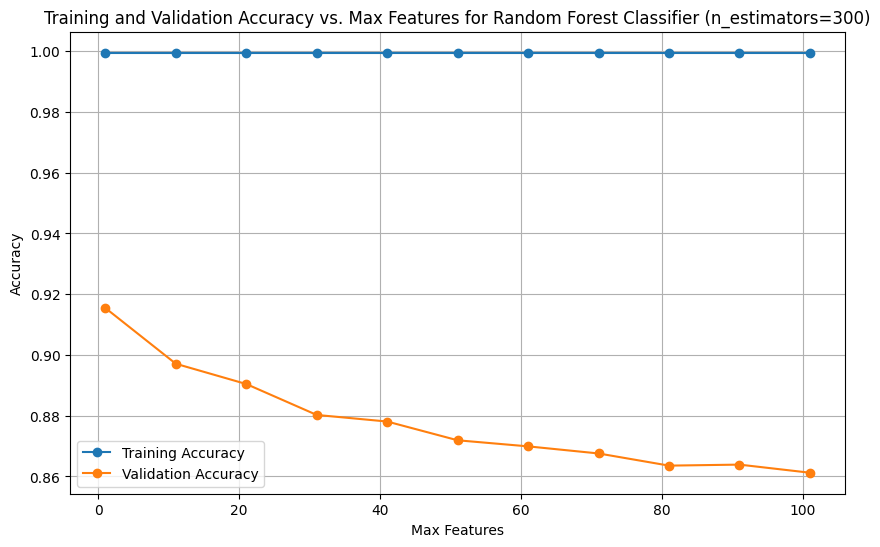

<IPython.core.display.Javascript object>

In [ ]:
%%notify
max_features_values = range(1, 102, 10)
train_accuracies = []
validation_accuracies = []

for max_features in max_features_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=300, max_features=max_features, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(max_features_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(max_features_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Max Features for Random Forest Classifier (n_estimators=300)')
plt.grid(True)
plt.legend()
plt.show()

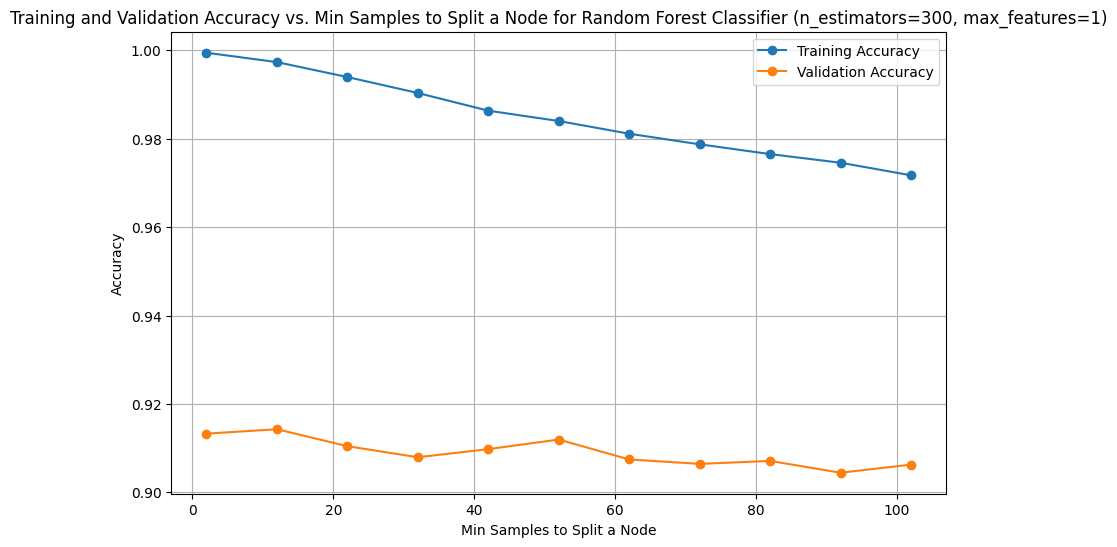

<IPython.core.display.Javascript object>

In [ ]:
%%notify
min_samples_split_values = range(2, 103, 10)
train_accuracies = []
validation_accuracies = []

for min_samples_split in min_samples_split_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=300, max_features=1, min_samples_split=min_samples_split, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(min_samples_split_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Min Samples to Split a Node')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Min Samples to Split a Node for Random Forest Classifier (n_estimators=300, max_features=1)')
plt.grid(True)
plt.legend()
plt.show()

# Model testing

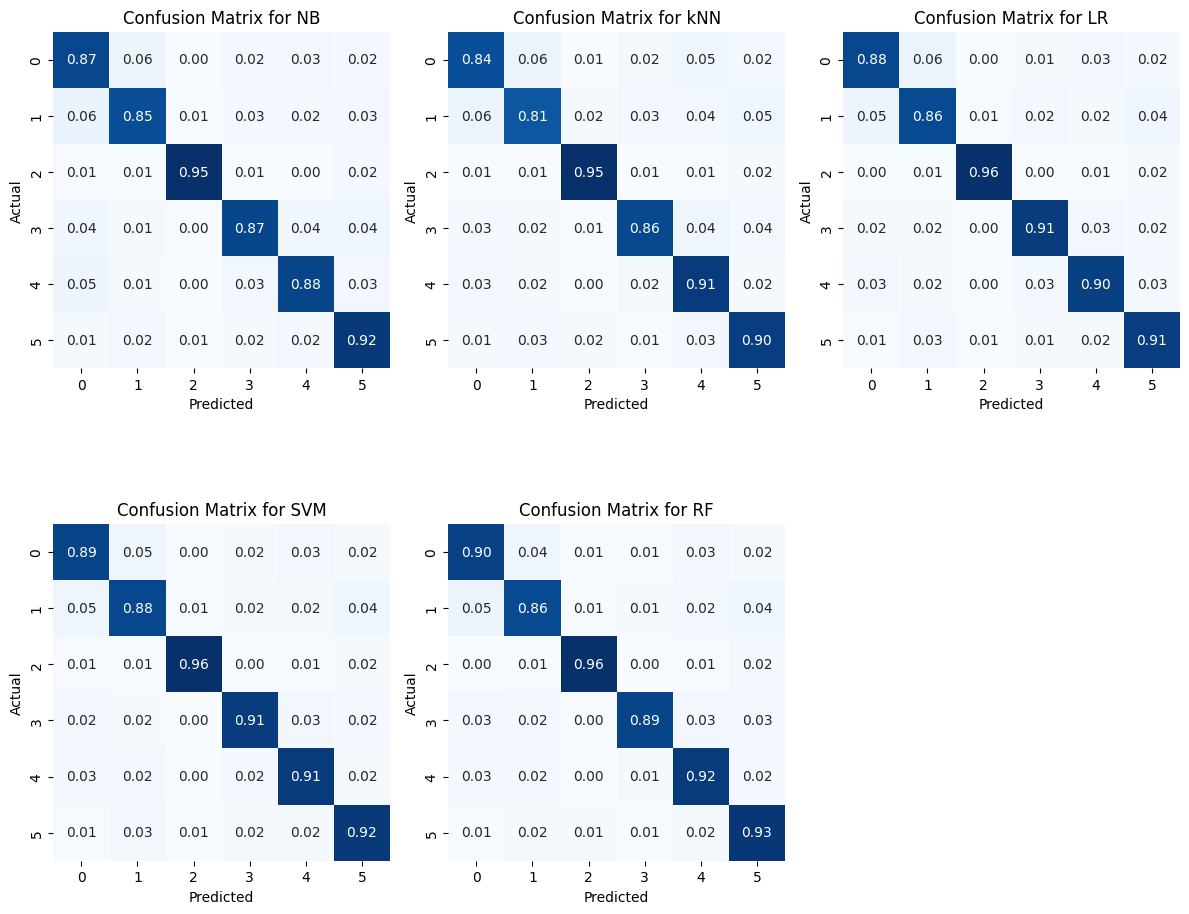

,Accuracy,Training Time (s),Testing Time (s)
NB,88.99%,0.42,0.06
kNN,87.88%,0.17,51.62
LR,90.36%,255.75,0.07
SVM,91.01%,3.28,0.06
RF,91.11%,37.36,2.81


<IPython.core.display.Javascript object>

In [ ]:
%%notify
import time

clf0 = MultinomialNB(alpha=0.1)
clf1 = KNeighborsClassifier(n_neighbors=101, weights='distance', metric='cosine', n_jobs=-1)
clf2 = LogisticRegression(C=10, max_iter=10000, n_jobs=-1)
clf3 = LinearSVC(C=1, loss='hinge', max_iter=10000)
clf4 = RandomForestClassifier(n_estimators=300, max_features=1, min_samples_split=12, n_jobs=-1)

classifiers = [clf0, clf1, clf2, clf3, clf4]
classifier_labels = ['NB', 'kNN', 'LR', 'SVM', 'RF']

training_times = []
testing_times = []
accuracies = []
confusion_matrices = []

for i, clf in enumerate(classifiers):
    with joblib.parallel_backend('loky'):
        start_time1 = time.time()
        clf.fit(X_train, y_train)
        end_time1 = time.time()
        training_time = end_time1 - start_time1
        training_times.append(training_time)

        start_time2 =time.time()
        y_pred = clf.predict(X_test)
        end_time2 = time.time()
        testing_time = end_time2 - start_time2
        testing_times.append(testing_time)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        confusion = confusion_matrix(y_test, y_pred, normalize='true')
        confusion_matrices.append(confusion)

#         model_filename = f'models/clf{i}.joblib'
#         joblib.dump(clf, model_filename)

plt.figure(figsize=(12, 10))

for i, clf_label in enumerate(classifier_labels):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(confusion_matrices[i], annot=True, fmt='.2f', cbar=False, cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_, square=True)
    plt.title(f'Confusion Matrix for {clf_label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

test_results = {'Accuracy': [f'{acc * 100:.2f}%' for acc in accuracies],
                'Training Time (s)': [f'{time:.2f}' for time in training_times],
                'Testing Time (s)': [f'{time:.2f}' for time in testing_times]}
display(pd.DataFrame(test_results, index=classifier_labels))